In [1]:
# importing required packages
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, scale, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import shap

In [2]:
Major = pd.read_csv('./Data/Feature Selected Data/US_Accidents_Road_DR_PS_Major.csv')
Minor = pd.read_csv('./Data/Feature Selected Data/US_Accidents_Road_DR_PS_Minor.csv')
Minor.dtypes
sevle_mn = LabelEncoder()
Minor['sev_cat'] = sevle_mn.fit_transform(Minor['sev_cat'])
print("Severity Type (Minor) : ",sevle_mn.classes_)
sevle_mj = LabelEncoder()
Major['sev_cat'] = sevle_mj.fit_transform(Major['sev_cat'])
print("Severity Type (Major) : ",sevle_mj.classes_)
side = LabelEncoder()
Minor['Side'] = side.fit_transform(Minor['Side'])
Major['Side'] = side.fit_transform(Major['Side'])
print("Side : ",side.classes_)
Wind_Direction = LabelEncoder()
Minor['Wind_Direction'] = Wind_Direction.fit_transform(Minor['Wind_Direction'])
Major['Wind_Direction'] = Wind_Direction.fit_transform(Major['Wind_Direction'])
print("Wind_Direction : ",Wind_Direction.classes_)
Weather_Condition = LabelEncoder()
Minor['Weather_Condition'] = Weather_Condition.fit_transform(Minor['Weather_Condition'])
Major['Weather_Condition'] = Weather_Condition.fit_transform(Major['Weather_Condition'])
print("Weather_Condition : ",Weather_Condition.classes_)
Sunrise_Sunset = LabelEncoder()
Minor['Sunrise_Sunset'] = Sunrise_Sunset.fit_transform(Minor['Sunrise_Sunset'])
Major['Sunrise_Sunset'] = Sunrise_Sunset.fit_transform(Major['Sunrise_Sunset'])
print("Sunrise_Sunset : ",Sunrise_Sunset.classes_)
highway = LabelEncoder()
Minor['highway'] = highway.fit_transform(Minor['highway'])
Major['highway'] = highway.fit_transform(Major['highway'])
print("highway : ",highway.classes_)
maxspeed = LabelEncoder()
Minor['maxspeed'] = maxspeed.fit_transform(Minor['maxspeed'])
Major['maxspeed'] = maxspeed.fit_transform(Major['maxspeed'])
print("maxspeed : ",maxspeed.classes_)

Severity Type (Minor) :  ['Minor 125 to 250' 'Minor 75 to 125' 'Minor above 250' 'Minor below 75']
Severity Type (Major) :  ['Major 125 to 250' 'Major 75 to 125' 'Major above 250' 'Major below 75']
Side :  ['L' 'R']
Wind_Direction :  ['CALM' 'E' 'N' 'NE' 'NW' 'S' 'SE' 'SW' 'VAR' 'W']
Weather_Condition :  ['Clear' 'Cloudy' 'Drizzle' 'Fair' 'Fog' 'Mist' 'Rain' 'Snow' 'T-Storm'
 'Windy' 'Wintry Mix']
Sunrise_Sunset :  ['Day' 'Night']
highway :  ['motorway' 'primary' 'residential' 'secondary' 'tertiary' 'trunk'
 'unclassified']
maxspeed :  [ 5 10 15 20 25 30 35 40 45 50 55 60 65 75]


In [3]:
Minor[['Distance','Humidity','Temperature','Pressure','Visibility','Wind_Speed','Precipitation']] = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(Minor[['Distance','Humidity','Temperature','Pressure','Visibility','Wind_Speed','Precipitation']])
Major[['Distance','Humidity','Temperature','Pressure','Visibility','Wind_Speed','Precipitation']] = PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(Major[['Distance','Humidity','Temperature','Pressure','Visibility','Wind_Speed','Precipitation']])

In [4]:
Minor[['Crossing','Traffic_Signal','oneway']] = Minor[['Crossing','Traffic_Signal','oneway']].astype(int)
Major[['Junction','Traffic_Signal','oneway']] = Major[['Junction','Traffic_Signal','oneway']].astype(int)

In [5]:
def dnn_model_min():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(Minor.shape[1]-1,)))
    model.add(layers.Dense(1024, activation='tanh', activity_regularizer='l2'))
    model.add(layers.Reshape((8, 128)))
    model.add(layers.Conv1D(filters=30, kernel_size=6, activation='tanh', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(512, dropout=0.1,))
    model.add(layers.Dense(256, activation='selu', activity_regularizer='l1_l2'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dense(512, activation='tanh', activity_regularizer='l2'))
    model.add(layers.PReLU())
    model.add(layers.Dense(512, activation='selu', activity_regularizer='l1_l2'))
    model.add(layers.Reshape((2, 256)))
    model.add(layers.GRU(128))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['sparse_categorical_accuracy'])
    return model

In [6]:
def dnn_model_maj():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(Major.shape[1]-1,)))
    model.add(layers.Dense(512, activation='tanh', activity_regularizer='l2'))
    model.add(layers.Reshape((8, 64)))
    model.add(layers.Conv1D(filters=30, kernel_size=6, activation='tanh', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(256, dropout=0.1,))
    model.add(layers.Dense(128, activation='selu', activity_regularizer='l1_l2'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dense(256, activation='tanh', activity_regularizer='l2'))
    model.add(layers.PReLU())
    model.add(layers.Dense(256, activation='selu', activity_regularizer='l1_l2'))
    model.add(layers.Reshape((2, 128)))
    model.add(layers.GRU(64))
    model.add(layers.Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['sparse_categorical_accuracy'])
    return model

In [7]:
skf = StratifiedKFold(n_splits = 10, random_state = 2, shuffle = True)
x = Minor.loc[:, Minor.columns != 'sev_cat'].to_numpy()
y = Minor['sev_cat'].to_numpy()
i=1
model_min = dnn_model_min()
for train_index, test_index in skf.split(x, y):
    train = Minor.iloc[list(train_index)]
    test = Minor.iloc[list(test_index)]
    x_train_min = train.loc[:, train.columns != 'sev_cat']
    y_train_min = train['sev_cat']
    x_test_min = test.loc[:, train.columns != 'sev_cat']
    y_test_min = test['sev_cat']
    batch_size = 390 #2250
    history_min = model_min.fit(x_train_min, y_train_min, epochs=25, validation_data=(x_test_min, y_test_min), verbose=0, batch_size=batch_size)
    print('KFOLD : ',i)
    i+=1
    print('Train Accuracy :',history_min.history['sparse_categorical_accuracy'][-1])
    print('Test Accuracy :',history_min.history['val_sparse_categorical_accuracy'][-1])

KFOLD :  1
Train Accuracy : 0.5233967900276184
Test Accuracy : 0.5344933271408081
KFOLD :  2
Train Accuracy : 0.5789485573768616
Test Accuracy : 0.5688843131065369
KFOLD :  3
Train Accuracy : 0.6014240384101868
Test Accuracy : 0.5830091834068298
KFOLD :  4
Train Accuracy : 0.6297459006309509
Test Accuracy : 0.5897645950317383
KFOLD :  5
Train Accuracy : 0.6704049110412598
Test Accuracy : 0.5978705883026123
KFOLD :  6
Train Accuracy : 0.7448362112045288
Test Accuracy : 0.6310401558876038
KFOLD :  7
Train Accuracy : 0.8146724104881287
Test Accuracy : 0.6857084631919861
KFOLD :  8
Train Accuracy : 0.8625568747520447
Test Accuracy : 0.7409909963607788
KFOLD :  9
Train Accuracy : 0.8953366875648499
Test Accuracy : 0.7934070229530334
KFOLD :  10
Train Accuracy : 0.9095768928527832
Test Accuracy : 0.8460278511047363


In [8]:
model_min.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              18432     
_________________________________________________________________
reshape (Reshape)            (None, 8, 128)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 30)             23070     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 30)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1112064   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0

In [9]:
skf = StratifiedKFold(n_splits = 10, random_state = 2, shuffle = True)
x = Major.loc[:, Major.columns != 'sev_cat'].to_numpy()
y = Major['sev_cat'].to_numpy()
i=1
model_maj = dnn_model_maj()
for train_index, test_index in skf.split(x, y):
    train = Major.iloc[list(train_index)]
    test = Major.iloc[list(test_index)]
    x_train_maj = train.loc[:, train.columns != 'sev_cat']
    y_train_maj = train['sev_cat']
    x_test_maj = test.loc[:, train.columns != 'sev_cat']
    y_test_maj = test['sev_cat']
    batch_size = 85 #390
    history_maj = model_maj.fit(x_train_maj, y_train_maj, epochs=25, validation_data=(x_test_maj, y_test_maj), verbose=0, batch_size=batch_size)
    print('KFOLD : ',i)
    i+=1
    print('Train Accuracy :',history_maj.history['sparse_categorical_accuracy'][-1])
    print('Test Accuracy :',history_maj.history['val_sparse_categorical_accuracy'][-1])

KFOLD :  1
Train Accuracy : 0.6190164089202881
Test Accuracy : 0.588443398475647
KFOLD :  2
Train Accuracy : 0.7213114500045776
Test Accuracy : 0.6415094137191772
KFOLD :  3
Train Accuracy : 0.7927868962287903
Test Accuracy : 0.7087264060974121
KFOLD :  4
Train Accuracy : 0.8463152647018433
Test Accuracy : 0.7308146357536316
KFOLD :  5
Train Accuracy : 0.8856543302536011
Test Accuracy : 0.7556080222129822
KFOLD :  6
Train Accuracy : 0.9076842665672302
Test Accuracy : 0.8146399259567261
KFOLD :  7
Train Accuracy : 0.9273537993431091
Test Accuracy : 0.8665879368782043
KFOLD :  8
Train Accuracy : 0.9362706542015076
Test Accuracy : 0.8701298832893372
KFOLD :  9
Train Accuracy : 0.9441384673118591
Test Accuracy : 0.885478138923645
KFOLD :  10
Train Accuracy : 0.9512194991111755
Test Accuracy : 0.9031876921653748


In [10]:
model_maj.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               9216      
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 30)             11550     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               293888    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)              

In [11]:
sknn_min_tr = history_min.history['sparse_categorical_accuracy'][-1]
sknn_min_ts = history_min.history['val_sparse_categorical_accuracy'][-1]
print('Training Accuracy (Minor) :',sknn_min_tr)
print('Test Accuracy (Minor) :',sknn_min_ts)
sknn_maj_tr = history_maj.history['sparse_categorical_accuracy'][-1]
sknn_maj_ts = history_maj.history['val_sparse_categorical_accuracy'][-1]
print('Training Accuracy (Major) :',sknn_maj_tr)
print('Test Accuracy (Major) :',sknn_maj_ts)

Training Accuracy (Minor) : 0.9095768928527832
Test Accuracy (Minor) : 0.8460278511047363
Training Accuracy (Major) : 0.9512194991111755
Test Accuracy (Major) : 0.9031876921653748


In [12]:
bc_min = BaggingClassifier(random_state=5)
bc_maj = BaggingClassifier(random_state=5)
bc_min.fit(x_train_min, y_train_min)
bc_maj.fit(x_train_maj, y_train_maj)
bc_min_tr = bc_min.score(x_train_min, y_train_min)
bc_min_ts = bc_min.score(x_test_min, y_test_min)
bc_maj_tr = bc_maj.score(x_train_maj, y_train_maj)
bc_maj_ts = bc_maj.score(x_test_maj, y_test_maj)
print('Training Accuracy (Minor) :',bc_min_tr)
print('Test Accuracy (Minor) :',bc_min_ts)
print('Training Accuracy (Major) :',bc_maj_tr)
print('Test Accuracy (Major) :',bc_maj_ts)

Training Accuracy (Minor) : 0.9749317561419473
Test Accuracy (Minor) : 0.579033579033579
Training Accuracy (Major) : 0.9854445318646735
Test Accuracy (Major) : 0.6493506493506493


In [13]:
etc_min = ExtraTreesClassifier(random_state=5)
etc_maj = ExtraTreesClassifier(random_state=5)
etc_min.fit(x_train_min, y_train_min)
etc_maj.fit(x_train_maj, y_train_maj)
etc_min_tr = etc_min.score(x_train_min, y_train_min)
etc_min_ts = etc_min.score(x_test_min, y_test_min)
etc_maj_tr = etc_maj.score(x_train_maj, y_train_maj)
etc_maj_ts = etc_maj.score(x_test_maj, y_test_maj)
print('Training Accuracy (Minor) :',etc_min_tr)
print('Test Accuracy (Minor) :',etc_min_ts)
print('Training Accuracy (Major) :',etc_maj_tr)
print('Test Accuracy (Major) :',etc_maj_ts)

Training Accuracy (Minor) : 0.989877161055505
Test Accuracy (Minor) : 0.5829238329238329
Training Accuracy (Major) : 0.9956726986624705
Test Accuracy (Major) : 0.6835891381345927


In [14]:
xgb_min = XGBClassifier(random_state=5)
xgb_maj = XGBClassifier(random_state=5)
xgb_min.fit(x_train_min, y_train_min)
xgb_maj.fit(x_train_maj, y_train_maj)
xgb_min_tr = xgb_min.score(x_train_min, y_train_min)
xgb_min_ts = xgb_min.score(x_test_min, y_test_min)
xgb_maj_tr = xgb_maj.score(x_train_maj, y_train_maj)
xgb_maj_ts = xgb_maj.score(x_test_maj, y_test_maj)
print('Training Accuracy (Minor) :',xgb_min_tr)
print('Test Accuracy (Minor) :',xgb_min_ts)
print('Training Accuracy (Major) :',xgb_maj_tr)
print('Test Accuracy (Major) :',xgb_maj_ts)

Training Accuracy (Minor) : 0.6575523202911738
Test Accuracy (Minor) : 0.5624488124488124
Training Accuracy (Major) : 0.9045371098872279
Test Accuracy (Major) : 0.6611570247933884


In [15]:
lgb_min = LGBMClassifier(random_state=5)
lgb_maj = LGBMClassifier(random_state=5)
lgb_min.fit(x_train_min, y_train_min)
lgb_maj.fit(x_train_maj, y_train_maj)
lgb_min_tr = lgb_min.score(x_train_min, y_train_min)
lgb_min_ts = lgb_min.score(x_test_min, y_test_min)
lgb_maj_tr = lgb_maj.score(x_train_maj, y_train_maj)
lgb_maj_ts = lgb_maj.score(x_test_maj, y_test_maj)
print('Training Accuracy (Minor) :',lgb_min_tr)
print('Test Accuracy (Minor) :',lgb_min_ts)
print('Training Accuracy (Major) :',lgb_maj_tr)
print('Test Accuracy (Major) :',lgb_maj_ts)

Training Accuracy (Minor) : 0.5979299363057324
Test Accuracy (Minor) : 0.5563063063063063
Training Accuracy (Major) : 0.8027799632835038
Test Accuracy (Major) : 0.641086186540732


In [16]:
cbc_min = CatBoostClassifier(random_state=5, verbose=0)
cbc_maj = CatBoostClassifier(random_state=5, verbose=0)
cbc_min.fit(x_train_min, y_train_min)
cbc_maj.fit(x_train_maj, y_train_maj)
cbc_min_tr = cbc_min.score(x_train_min, y_train_min)
cbc_min_ts = cbc_min.score(x_test_min, y_test_min)
cbc_maj_tr = cbc_maj.score(x_train_maj, y_train_maj)
cbc_maj_ts = cbc_maj.score(x_test_maj, y_test_maj)
print('Training Accuracy (Minor) :',cbc_min_tr)
print('Test Accuracy (Minor) :',cbc_min_ts)
print('Training Accuracy (Major) :',cbc_maj_tr)
print('Test Accuracy (Major) :',cbc_maj_ts)

Training Accuracy (Minor) : 0.6583257506824386
Test Accuracy (Minor) : 0.5659295659295659
Training Accuracy (Major) : 0.8932599003409389
Test Accuracy (Major) : 0.6363636363636364


In [19]:
sknn_min_pred = model_min.predict_classes(x_test_min)
sknn_maj_pred = model_maj.predict_classes(x_test_maj)
bc_min_pred = bc_min.predict(x_test_min)
bc_maj_pred = bc_maj.predict(x_test_maj)
etc_min_pred = etc_min.predict(x_test_min)
etc_maj_pred = etc_maj.predict(x_test_maj)
xgb_min_pred = xgb_min.predict(x_test_min)
xgb_maj_pred = xgb_maj.predict(x_test_maj)
lgb_min_pred = lgb_min.predict(x_test_min)
lgb_maj_pred = lgb_maj.predict(x_test_maj)
cbc_min_pred = np.array(list(flatten(cbc_min.predict(x_test_min))))
cbc_maj_pred = np.array(list(flatten(cbc_maj.predict(x_test_maj))))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [20]:
sknn_min_ps = precision_score(y_test_min, sknn_min_pred, average='weighted')
bc_min_ps = precision_score(y_test_min, bc_min_pred, average='weighted')
etc_min_ps = precision_score(y_test_min, etc_min_pred, average='weighted')
xgb_min_ps = precision_score(y_test_min, xgb_min_pred, average='weighted')
lgb_min_ps = precision_score(y_test_min, lgb_min_pred, average='weighted')
cbc_min_ps = precision_score(y_test_min, cbc_min_pred, average='weighted')
sknn_min_f1 = f1_score(y_test_min, sknn_min_pred, average='weighted')
bc_min_f1 = f1_score(y_test_min, bc_min_pred, average='weighted')
etc_min_f1 = f1_score(y_test_min, etc_min_pred, average='weighted')
xgb_min_f1 = f1_score(y_test_min, xgb_min_pred, average='weighted')
lgb_min_f1 = f1_score(y_test_min, lgb_min_pred, average='weighted')
cbc_min_f1 = f1_score(y_test_min, cbc_min_pred, average='weighted')
sknn_min_rs = recall_score(y_test_min, sknn_min_pred, average='weighted')
bc_min_rs = recall_score(y_test_min, bc_min_pred, average='weighted')
etc_min_rs = recall_score(y_test_min, etc_min_pred, average='weighted')
xgb_min_rs = recall_score(y_test_min, xgb_min_pred, average='weighted')
lgb_min_rs = recall_score(y_test_min, lgb_min_pred, average='weighted')
cbc_min_rs = recall_score(y_test_min, cbc_min_pred, average='weighted')

In [21]:
sknn_maj_ps = precision_score(y_test_maj, sknn_maj_pred, average='weighted')
bc_maj_ps = precision_score(y_test_maj, bc_maj_pred, average='weighted')
etc_maj_ps = precision_score(y_test_maj, etc_maj_pred, average='weighted')
xgb_maj_ps = precision_score(y_test_maj, xgb_maj_pred, average='weighted')
lgb_maj_ps = precision_score(y_test_maj, lgb_maj_pred, average='weighted')
cbc_maj_ps = precision_score(y_test_maj, cbc_maj_pred, average='weighted')
sknn_maj_f1 = f1_score(y_test_maj, sknn_maj_pred, average='weighted')
bc_maj_f1 = f1_score(y_test_maj, bc_maj_pred, average='weighted')
etc_maj_f1 = f1_score(y_test_maj, etc_maj_pred, average='weighted')
xgb_maj_f1 = f1_score(y_test_maj, xgb_maj_pred, average='weighted')
lgb_maj_f1 = f1_score(y_test_maj, lgb_maj_pred, average='weighted')
cbc_maj_f1 = f1_score(y_test_maj, cbc_maj_pred, average='weighted')
sknn_maj_rs = recall_score(y_test_maj, sknn_maj_pred, average='weighted')
bc_maj_rs = recall_score(y_test_maj, bc_maj_pred, average='weighted')
etc_maj_rs = recall_score(y_test_maj, etc_maj_pred, average='weighted')
xgb_maj_rs = recall_score(y_test_maj, xgb_maj_pred, average='weighted')
lgb_maj_rs = recall_score(y_test_maj, lgb_maj_pred, average='weighted')
cbc_maj_rs = recall_score(y_test_maj, cbc_maj_pred, average='weighted')

In [22]:
models = ['Stratified Kfold DNN', 'Bagging Classifier', 'Extra Trees Classifier', 'XGBoost Classifier', 'LGBM Classifier', 'Cat Boost Classifier']
train_acc_min = [sknn_min_tr, bc_min_tr, etc_min_tr, xgb_min_tr, lgb_min_tr, cbc_min_tr]
test_acc_min = [sknn_min_ts, bc_min_ts, etc_min_ts, xgb_min_ts, lgb_min_ts, cbc_min_ts]
precision_min = [sknn_min_ps, bc_min_ps, etc_min_ps, xgb_min_ps, lgb_min_ps, cbc_min_ps]
recall_min = [sknn_min_rs, bc_min_rs, etc_min_rs, xgb_min_rs, lgb_min_rs, cbc_min_rs]
f1_score_min = [sknn_min_f1, bc_min_f1, etc_min_f1, xgb_min_f1, lgb_min_f1, cbc_min_f1]
Minor_Eval = pd.DataFrame({
    'Model Name':models,
    'Training Accuracy':train_acc_min,
    'Test Accuracy':test_acc_min,
    'Precision':precision_min,
    'Recall':recall_min,
    'F1 Score':f1_score_min
})
Minor_Eval

,Model Name,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Stratified Kfold DNN,0.909577,0.846028,0.846118,0.846028,0.845965
1,Bagging Classifier,0.974932,0.579034,0.584225,0.579034,0.580412
2,Extra Trees Classifier,0.989877,0.582924,0.583577,0.582924,0.583121
3,XGBoost Classifier,0.657552,0.562449,0.572329,0.562449,0.564459
4,LGBM Classifier,0.597930,0.556306,0.571043,0.556306,0.559031
5,Cat Boost Classifier,0.658326,0.565930,0.573806,0.565930,0.567876


In [23]:
models = ['Stratified Kfold DNN', 'Bagging Classifier', 'Extra Trees Classifier', 'XGBoost Classifier', 'LGBM Classifier', 'Cat Boost Classifier']
train_acc_maj = [sknn_maj_tr, bc_maj_tr, etc_maj_tr, xgb_maj_tr, lgb_maj_tr, cbc_maj_tr]
test_acc_maj = [sknn_maj_ts, bc_maj_ts, etc_maj_ts, xgb_maj_ts, lgb_maj_ts, cbc_maj_ts]
precision_maj = [sknn_maj_ps, bc_maj_ps, etc_maj_ps, xgb_maj_ps, lgb_maj_ps, cbc_maj_ps]
recall_maj = [sknn_maj_rs, bc_maj_rs, etc_maj_rs, xgb_maj_rs, lgb_maj_rs, cbc_maj_rs]
f1_score_maj = [sknn_maj_f1, bc_maj_f1, etc_maj_f1, xgb_maj_f1, lgb_maj_f1, cbc_maj_f1]
Major_Eval = pd.DataFrame({
    'Model Name':models,
    'Training Accuracy':train_acc_maj,
    'Test Accuracy':test_acc_maj,
    'Precision':precision_maj,
    'Recall':recall_maj,
    'F1 Score':f1_score_maj
})
Major_Eval

,Model Name,Training Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Stratified Kfold DNN,0.951219,0.903188,0.903762,0.903188,0.903226
1,Bagging Classifier,0.985445,0.649351,0.656028,0.649351,0.650864
2,Extra Trees Classifier,0.995673,0.683589,0.684990,0.683589,0.683518
3,XGBoost Classifier,0.904537,0.661157,0.663650,0.661157,0.660648
4,LGBM Classifier,0.802780,0.641086,0.641410,0.641086,0.639744
5,Cat Boost Classifier,0.893260,0.636364,0.635740,0.636364,0.635108


In [17]:
min_explainer_shap = shap.GradientExplainer(model=model_min, data=x_test_min.to_numpy())
min_shap_values = min_explainer_shap.shap_values(x_test_min.to_numpy())

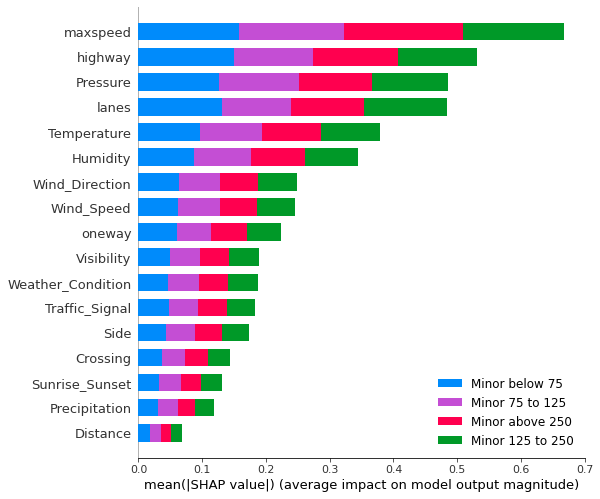

In [24]:
shap.summary_plot(min_shap_values, x_test_min.to_numpy(), feature_names=Minor.loc[:, Minor.columns != 'sev_cat'].columns, class_names=['Minor 125 to 250','Minor 75 to 125','Minor above 250','Minor below 75'])

In [18]:
maj_explainer_shap = shap.GradientExplainer(model=model_maj, data=x_test_maj.to_numpy())
maj_shap_values = maj_explainer_shap.shap_values(x_test_maj.to_numpy())

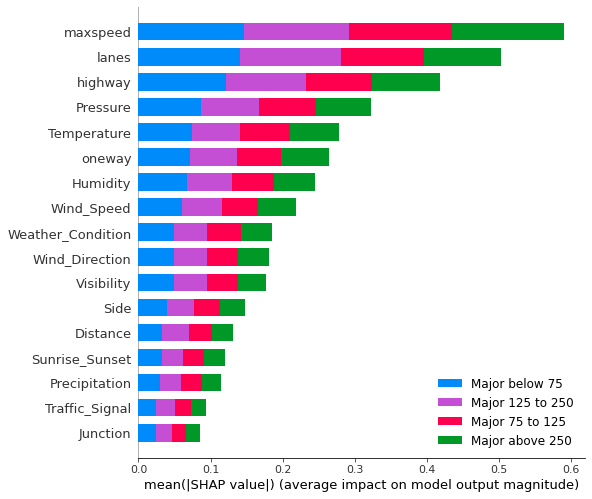

In [25]:
shap.summary_plot(maj_shap_values, x_test_maj.to_numpy(), feature_names=Major.loc[:, Major.columns != 'sev_cat'].columns, class_names=['Major 125 to 250','Major 75 to 125','Major above 250','Major below 75'])

In [26]:
min_class0 = pd.DataFrame(min_shap_values[0], columns = list(Minor.loc[:, Minor.columns != 'sev_cat'].columns))
min_class1 = pd.DataFrame(min_shap_values[1], columns = list(Minor.loc[:, Minor.columns != 'sev_cat'].columns))
min_class2 = pd.DataFrame(min_shap_values[2], columns = list(Minor.loc[:, Minor.columns != 'sev_cat'].columns))
min_class3 = pd.DataFrame(min_shap_values[3], columns = list(Minor.loc[:, Minor.columns != 'sev_cat'].columns))

In [27]:
maj_class0 = pd.DataFrame(maj_shap_values[0], columns = list(Major.loc[:, Major.columns != 'sev_cat'].columns))
maj_class1 = pd.DataFrame(maj_shap_values[1], columns = list(Major.loc[:, Major.columns != 'sev_cat'].columns))
maj_class2 = pd.DataFrame(maj_shap_values[2], columns = list(Major.loc[:, Major.columns != 'sev_cat'].columns))
maj_class3 = pd.DataFrame(maj_shap_values[3], columns = list(Major.loc[:, Major.columns != 'sev_cat'].columns))

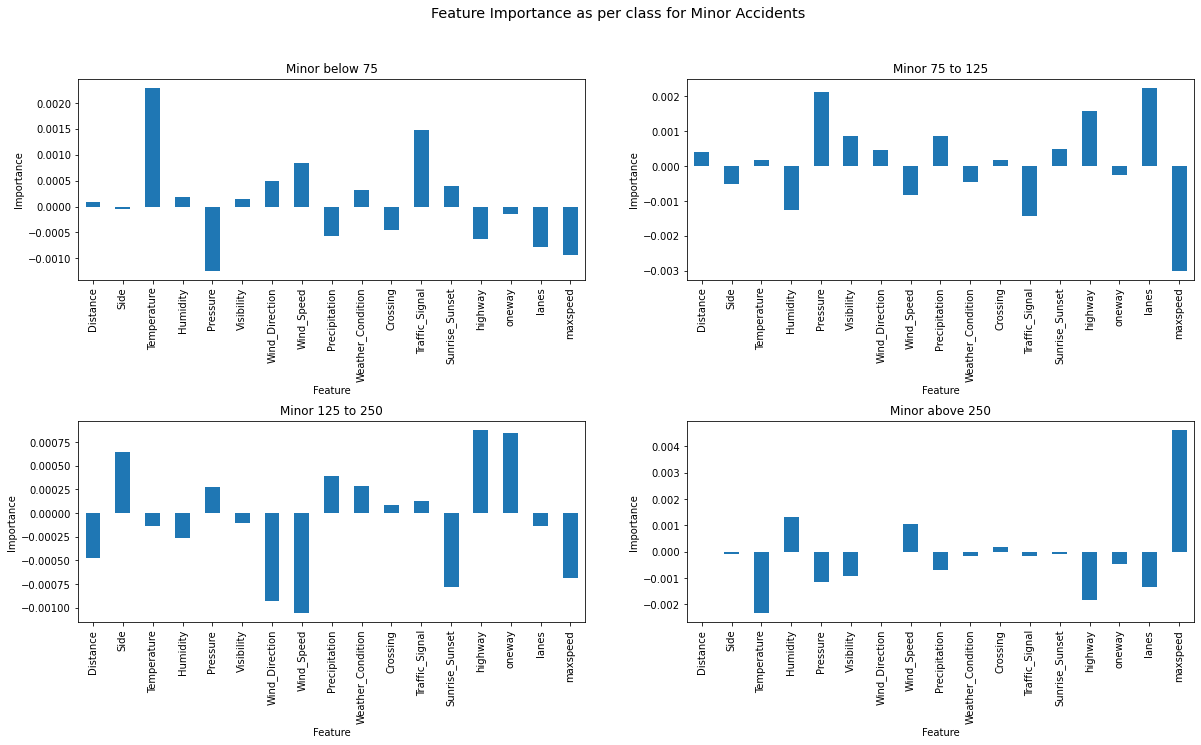

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.sca(ax[0,0])
min_class3.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Minor below 75')
plt.sca(ax[0,1])
min_class1.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Minor 75 to 125')
plt.sca(ax[1,0])
min_class0.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Minor 125 to 250')
plt.sca(ax[1,1])
min_class2.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Minor above 250')
fig.suptitle('Feature Importance as per class for Minor Accidents', fontsize='x-large')
fig.subplots_adjust(hspace=0.7)

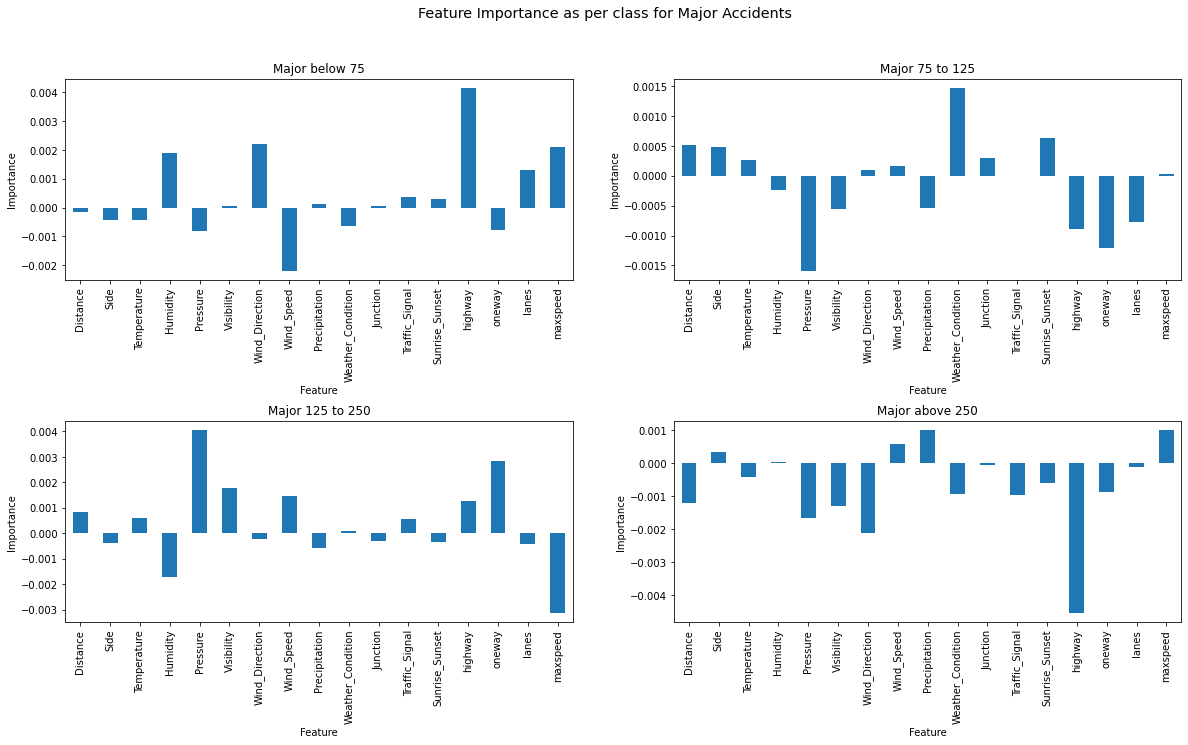

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.sca(ax[0,0])
maj_class3.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Major below 75')
plt.sca(ax[0,1])
maj_class1.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Major 75 to 125')
plt.sca(ax[1,0])
maj_class0.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Major 125 to 250')
plt.sca(ax[1,1])
maj_class2.mean(axis = 0).plot(kind='bar')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Major above 250')
fig.suptitle('Feature Importance as per class for Major Accidents', fontsize='x-large')
fig.subplots_adjust(hspace=0.7)